In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
import random


In [ ]:
train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
train_df.head()

In [ ]:
print('Shape of Training data: ', train_df.shape)
print('Shape of Test data: ', test_df.shape)

print(f"The total patient ids are {train_df['Patient'].count()}")
print(f"Number of unique ids are {train_df['Patient'].value_counts().shape[0]} ")

In [ ]:
sub["Patient"]=sub["Patient_Week"].apply(lambda x: x.split("_")[0])
sub["Weeks"]=sub["Patient_Week"].apply(lambda x: x.split("_")[1]).astype(int)
sub=sub.drop(["FVC","Patient_Week","Confidence"],axis=1)
submission=sub[["Patient","Weeks"]].merge(test_df,on=["Patient","Weeks"],how="left")
for col in ["Age","Sex","SmokingStatus"]:
    submission[col]=submission.groupby("Patient")[col].apply(lambda x : x.ffill())
    submission[col]=submission.groupby("Patient")[col].apply(lambda x : x.bfill())
submission.head()#.isnull().sum(),submission.shape

In [ ]:
# Remove duplicated records--*not deduplication, remove test patients

print(train_df.shape)
train_df=train_df.drop_duplicates(keep=False, subset=['Patient','Weeks'])
print(train_df.shape)
train_df=train_df[train_df["Patient"].isin(list(submission["Patient"].unique()))==False]
print(train_df.shape)

In [ ]:
# Feat eng1
train_df.reset_index(drop=True,inplace=True)
train_df=train_df.sort_values("Weeks")
train_df["c_first_week"]=train_df.groupby("Patient")["Weeks"].transform("min")
train_df.loc[train_df["c_first_week"]==train_df["Weeks"],"c_first_FVC"]=train_df["FVC"]
train_df["c_first_FVC"]=train_df.groupby("Patient")["c_first_FVC"].apply(lambda x: x.ffill())
train_df.loc[train_df["c_first_week"]==train_df["Weeks"],"c_first_PCT"]=train_df["Percent"]
train_df["c_first_PCT"]=train_df.groupby("Patient")["c_first_PCT"].apply(lambda x: x.ffill())
train_df["c_week_since_week"]=train_df["Weeks"]-train_df["c_first_week"]
train_df.head()

In [ ]:
# train_df.isnull().sum()

In [ ]:
# Feat eng1
submission.reset_index(drop=True,inplace=True)
submission.loc[submission["FVC"].notnull(),"c_first_week"]=submission["Weeks"]
submission.loc[submission["FVC"].notnull(),"c_first_FVC"]=submission["FVC"]
submission.loc[submission["Percent"].notnull(),"c_first_PCT"]=submission["Percent"]

submission["c_first_FVC"]=submission.groupby("Patient")["c_first_FVC"].apply(lambda x: x.ffill())
submission["c_first_FVC"]=submission.groupby("Patient")["c_first_FVC"].apply(lambda x: x.bfill())

submission["c_first_PCT"]=submission.groupby("Patient")["c_first_PCT"].apply(lambda x: x.ffill())
submission["c_first_PCT"]=submission.groupby("Patient")["c_first_PCT"].apply(lambda x: x.bfill())

submission["c_first_week"]=submission.groupby("Patient")["c_first_week"].apply(lambda x: x.ffill())
submission["c_first_week"]=submission.groupby("Patient")["c_first_week"].apply(lambda x: x.bfill())

submission["c_week_since_week"]=submission["Weeks"]-submission["c_first_week"]
submission

In [ ]:
# Feat eng 2
# Categorical- OHE
catcols=["SmokingStatus","Sex"]
uval_dicts={}
for col in catcols:
    uvals=train_df[col].unique()
    for val in uvals:
#         print(col,val)
        train_df.loc[train_df[col]==val,"ohe_"+val]=1
        train_df.loc[train_df[col]!=val,"ohe_"+val]=0
        
        submission.loc[submission[col]==val,"ohe_"+val]=1
        submission.loc[submission[col]!=val,"ohe_"+val]=0
    uval_dicts[col]=uvals

    
    
from sklearn import preprocessing
# Numerical normalzie

numcols=['Weeks','Age','c_first_week', 'c_first_FVC', 'c_week_since_week', 'c_first_PCT']
for col in numcols:
    le=preprocessing.StandardScaler()
    le.fit(np.array(train_df[col].tolist()+submission[col].tolist()).reshape(-1,1))
    train_df["n_"+col]=le.transform(train_df[col].values.reshape(-1,1)).flatten()
    submission["n_"+col]=le.transform(submission[col].values.reshape(-1,1)).flatten()
    
train_df.head()


submission.head()

In [ ]:
submission.columns

In [ ]:
train_df.columns

In [ ]:
numerical_features=[ 'n_Weeks', 'n_Age', 'n_c_first_week', 'n_c_first_FVC',
       'n_c_week_since_week', 'n_c_first_PCT',]
binary_features=['ohe_Never smoked', 'ohe_Ex-smoker', 'ohe_Currently smokes',
       'ohe_Female', 'ohe_Male']
target="FVC"

In [ ]:
# https://www.kaggle.com/andypenrose/osic-multiple-quantile-regression-starter/comments
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================

    
    

In [ ]:
def make_model(num_inputs,num_blocks,units,dropout):
    input_ = L.Input((num_inputs,), name="Patient")
    for _ in range(num_blocks):
        if _==0:
            x=L.Dense(units,activation="relu")(input_)
        else:
            x=L.Dense(units,activation="relu")(x)
        x=L.BatchNormalization()(x)
        x=L.Dropout(dropout)(x)
    
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(input_, preds, name="CNN")
    model.compile(loss=mloss(1), optimizer="adam", metrics=[score])
    return model

In [ ]:
# net = make_model(11,num_blocks=1,units=300,dropout=0.2)
# print(net.summary())
# print(net.count_params())

In [ ]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(2020)

In [ ]:
X=train_df[numerical_features+binary_features].values
y=train_df[target].astype(np.float32).values

X_test=submission[numerical_features+binary_features].values
X.shape,y.shape,X_test.shape

In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint("./bestmodel.chkpt",save_best_only=True,save_weights_only=True,\
                                                   mode="min",monitor="val_score")
lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=30, verbose=0, mode='min',
    min_delta=0.0001, cooldown=0, min_lr=0,)
es=tf.keras.callbacks.EarlyStopping(
    monitor='val_score', min_delta=0, patience=20, verbose=0, mode='min', restore_best_weights=True
)
CALLBACKS=[lr]

In [ ]:
from sklearn import model_selection
from tqdm import tqdm
import numpy as np

NFOLDS=5
BATCH_SIZE=100
EPOCHS=300
kf=model_selection.KFold(n_splits=NFOLDS, random_state=2020)
dfs=[]
validation=np.zeros((X.shape[0],3))
test_predictions=[]
val_scores=[]


for i,(train_index,val_index) in enumerate(kf.split(X)):
    print("Fold")
    print(i,len(train_index),len(val_index))
    X_train=X[train_index]
    y_train=y[train_index]
    X_val=X[val_index]
    y_val=y[val_index]
    
    model=make_model(X.shape[1],num_blocks=2,units=300,dropout=0.2)
    history=model.fit(X_train,y_train,\
              validation_data=(X_val,y_val),\
              batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=0,\
                     callbacks=CALLBACKS)
    
    y_pred=model.predict(X_val)
    val_score=score(y_val.reshape(-1,1),y_pred).numpy()
    print(f"Fold {i} Val score {val_score}")
    val_scores.append(val_score)
    
    
    test_predictions.append(model.predict(X_test))
    
    histdf=pd.DataFrame(history.history)
    histdf["epoch"]=history.epoch
    dfs.append(histdf)
    
    validation[val_index,:]=y_pred
#     break
    
    
    

print(f"mean OOF validation score: {np.mean(val_scores)} ")
print(f"min OOF validation score: {np.min(val_scores)} ")
print(f"max OOF validation score: {np.max(val_scores)} ")


findf=pd.DataFrame()

for col in dfs[0].columns:
    vals=np.zeros((EPOCHS,))
    for df in dfs:
        vals+=df[col].values
    findf[col]=vals/len(dfs)
findf["val_score"].plot()
plt.show()
findf["val_loss"].plot()
plt.show()

In [ ]:
print(findf["val_score"].tail())
findf["val_score"].plot()

In [ ]:
preds=np.zeros((X_test.shape[0],3))
for p in test_predictions:
    preds += p / NFOLDS
print(preds.shape)
preds[:3]

In [ ]:
sub=submission[["Patient","Weeks"]]
sub["FVC_median"]=preds[:,1]
sub["Confidence"]=preds[:,2]-preds[:,0]

In [ ]:
sub.isnull().sum()

In [ ]:
sub.describe().T

In [ ]:
sub["Patient_Week"]=sub.apply(lambda x: x["Patient"]+"_"+str(x["Weeks"]),axis=1)
sub

In [ ]:
sub.rename(columns={"FVC_median":"FVC"})[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv",index=False)

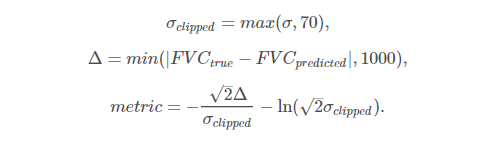

In [ ]:
def calculate_score(y_true, y_pred):
    
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    print(sigma)
    sigma_clip = sigma#np.clip(sigma,a_min=None,a_max= None)
    print(pd.Series(sigma_clip).value_counts())
    delta = np.abs(y_true - fvc_pred)
    print(delta)
#     delta = np.clip(delta,a_min=1000, a_max= None)
    print(pd.Series(delta).value_counts())
    sq2 = np.sqrt( 2)
    print(sq2)
    metric = (delta / sigma_clip)*sq2+np.log(sigma_clip* sq2) 
    print(metric)
    print(sigma_clip* sq2)
    print(np.log(sigma_clip* sq2))
    return - np.nanmean(metric)

In [ ]:
# calculate_score(y,validation)